# Emotion Recognition with VGG16 Model

This notebook trains a VGG16 model for emotion recognition using:
- Local video data (5 emotions: Angry, Happy, Sad, Neutral, Surprise)
- FER2013 dataset from Kaggle

The model will classify emotions from video frames extracted from the datasets.

In [2]:
%pip install kagglehub

  Using cached kagglehub-0.3.12-py3-none-any.whl.metadata (38 kB)
Using cached kagglehub-0.3.12-py3-none-any.whl (67 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install tensorflow

  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.73.1-cp310-cp310-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached h5py-3.14.0-cp310-cp310-win_amd64.whl.metadata (2.7 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached markdown-3.8.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 k

In [5]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: []


In [6]:
# Download FER2013 dataset from Kaggle
print("Downloading FER2013 dataset...")
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

# Set paths
fer2013_path = path
local_data_path = "data"  # Local video data path

# Define emotion classes (5 emotions)
emotion_classes = ['angry', 'happy', 'neutral', 'sad', 'surprise']
num_classes = len(emotion_classes)

print(f"Working with {num_classes} emotion classes: {emotion_classes}")

Path to dataset files: C:\Users\DELL\.cache\kagglehub\datasets\msambare\fer2013\versions\1
Working with 5 emotion classes: ['angry', 'happy', 'neutral', 'sad', 'surprise']


In [7]:
# Function to extract frames from video
def extract_frames_from_video(video_path, target_size=(224, 224), max_frames=30):
    """
    Extract frames from video and resize them
    Args:
        video_path: Path to video file
        target_size: Target size for frames (height, width)
        max_frames: Maximum number of frames to extract
    Returns:
        List of preprocessed frames
    """
    frames = []
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return frames
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(1, total_frames // max_frames)
    
    frame_count = 0
    extracted_count = 0
    
    while cap.isOpened() and extracted_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
            
        if frame_count % frame_interval == 0:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Resize frame
            frame_resized = cv2.resize(frame_rgb, target_size)
            # Normalize pixel values
            frame_normalized = frame_resized.astype(np.float32) / 255.0
            frames.append(frame_normalized)
            extracted_count += 1
            
        frame_count += 1
    
    cap.release()
    return frames

print("Frame extraction function defined successfully!")

Frame extraction function defined successfully!


In [8]:
# Load local video data
def load_video_data(data_path, emotion_classes):
    """Load video data from local directory structure"""
    video_data = []
    labels = []
    
    for split in ['train', 'test']:
        split_path = os.path.join(data_path, split)
        if not os.path.exists(split_path):
            print(f"Warning: {split_path} does not exist")
            continue
            
        for emotion_idx, emotion in enumerate(emotion_classes):
            emotion_path = os.path.join(split_path, emotion.capitalize())
            if not os.path.exists(emotion_path):
                print(f"Warning: {emotion_path} does not exist")
                continue
                
            video_files = [f for f in os.listdir(emotion_path) if f.endswith(('.mp4', '.avi', '.mov'))]
            print(f"Found {len(video_files)} videos in {emotion_path}")
            
            for video_file in video_files:
                video_path = os.path.join(emotion_path, video_file)
                frames = extract_frames_from_video(video_path)
                
                for frame in frames:
                    video_data.append(frame)
                    labels.append(emotion_idx)
    
    return np.array(video_data), np.array(labels)

# Load local video data
print("Loading local video data...")
X_video, y_video = load_video_data(local_data_path, emotion_classes)
print(f"Loaded {len(X_video)} frames from local videos")
print(f"Video data shape: {X_video.shape}")
print(f"Labels shape: {y_video.shape}")

Loading local video data...
Found 6 videos in data\train\Angry
Found 5 videos in data\train\Happy
Found 7 videos in data\train\Neutral
Found 6 videos in data\train\Sad
Found 1 videos in data\test\Angry
Found 1 videos in data\test\Happy
Found 1 videos in data\test\Neutral
Found 1 videos in data\test\Sad
Loaded 840 frames from local videos
Video data shape: (840, 224, 224, 3)
Labels shape: (840,)


In [9]:
# Load FER2013 dataset
def load_fer2013_data(fer2013_path, emotion_classes, target_size=(224, 224)):
    """Load and process FER2013 dataset"""
    # FER2013 emotion mapping (original has 7 classes, we need to map to our 5)
    fer2013_emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    
    # Mapping from FER2013 to our 5 classes
    emotion_mapping = {
        0: 0,  # angry -> angry
        1: 2,  # disgust -> neutral (merging)
        2: 2,  # fear -> neutral (merging)
        3: 1,  # happy -> happy
        4: 3,  # sad -> sad
        5: 4,  # surprise -> surprise
        6: 2   # neutral -> neutral
    }
    
    fer_data = []
    fer_labels = []
    
    # Look for train and test folders in FER2013 dataset
    for split in ['train', 'test']:
        split_path = os.path.join(fer2013_path, split)
        if not os.path.exists(split_path):
            continue
            
        for fer_emotion_idx, fer_emotion in enumerate(fer2013_emotions):
            emotion_folder = os.path.join(split_path, fer_emotion)
            if not os.path.exists(emotion_folder):
                continue
                
            # Map to our emotion classes
            if fer_emotion_idx in emotion_mapping:
                our_emotion_idx = emotion_mapping[fer_emotion_idx]
                
                image_files = [f for f in os.listdir(emotion_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
                print(f"Found {len(image_files)} images in {emotion_folder}")
                
                for img_file in image_files[:500]:  # Limit to 500 images per emotion to balance dataset
                    img_path = os.path.join(emotion_folder, img_file)
                    try:
                        # Load and preprocess image
                        img = load_img(img_path, target_size=target_size)
                        img_array = img_to_array(img) / 255.0
                        
                        fer_data.append(img_array)
                        fer_labels.append(our_emotion_idx)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
                        continue
    
    return np.array(fer_data), np.array(fer_labels)

# Load FER2013 data
print("Loading FER2013 dataset...")
X_fer, y_fer = load_fer2013_data(fer2013_path, emotion_classes)
print(f"Loaded {len(X_fer)} images from FER2013 dataset")
print(f"FER2013 data shape: {X_fer.shape}")
print(f"FER2013 labels shape: {y_fer.shape}")

Loading FER2013 dataset...
Found 3995 images in C:\Users\DELL\.cache\kagglehub\datasets\msambare\fer2013\versions\1\train\angry
Found 436 images in C:\Users\DELL\.cache\kagglehub\datasets\msambare\fer2013\versions\1\train\disgust
Found 4097 images in C:\Users\DELL\.cache\kagglehub\datasets\msambare\fer2013\versions\1\train\fear
Found 7215 images in C:\Users\DELL\.cache\kagglehub\datasets\msambare\fer2013\versions\1\train\happy
Found 4830 images in C:\Users\DELL\.cache\kagglehub\datasets\msambare\fer2013\versions\1\train\sad
Found 3171 images in C:\Users\DELL\.cache\kagglehub\datasets\msambare\fer2013\versions\1\train\surprise
Found 4965 images in C:\Users\DELL\.cache\kagglehub\datasets\msambare\fer2013\versions\1\train\neutral
Found 958 images in C:\Users\DELL\.cache\kagglehub\datasets\msambare\fer2013\versions\1\test\angry
Found 111 images in C:\Users\DELL\.cache\kagglehub\datasets\msambare\fer2013\versions\1\test\disgust
Found 1024 images in C:\Users\DELL\.cache\kagglehub\datasets\ms

Combining datasets...
Combined dataset shape: (7387, 224, 224, 3)
Combined labels shape: (7387,)

Class distribution:
angry: 1210 samples
happy: 1180 samples
neutral: 2787 samples
sad: 1210 samples
surprise: 1000 samples


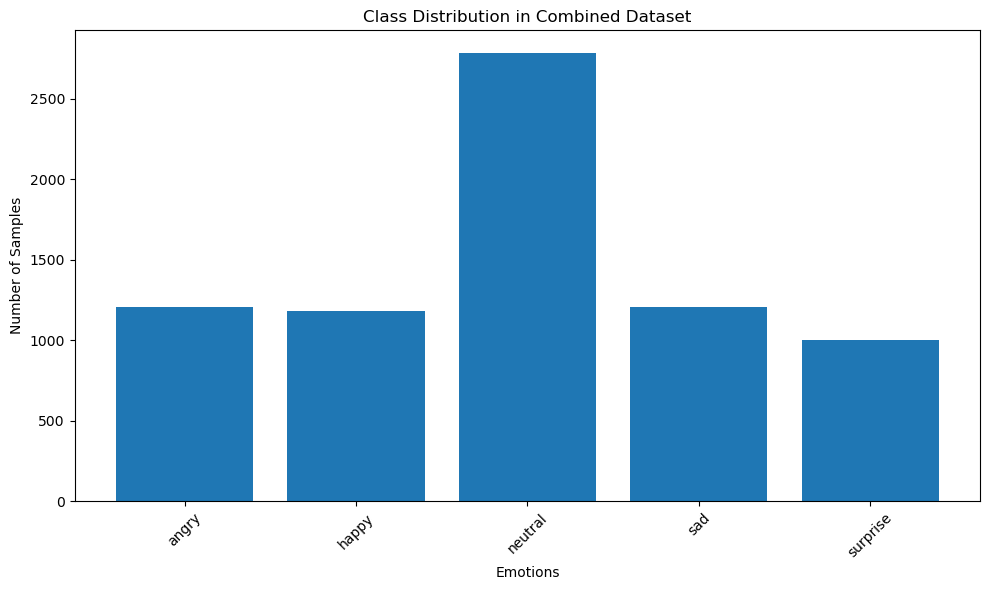

In [10]:
# Combine video and FER2013 datasets
print("Combining datasets...")

# Combine data
if len(X_video) > 0 and len(X_fer) > 0:
    X_combined = np.vstack([X_video, X_fer])
    y_combined = np.hstack([y_video, y_fer])
elif len(X_video) > 0:
    X_combined = X_video
    y_combined = y_video
    print("Using only video data (FER2013 data not available)")
elif len(X_fer) > 0:
    X_combined = X_fer
    y_combined = y_fer
    print("Using only FER2013 data (video data not available)")
else:
    raise ValueError("No data available from either source!")

print(f"Combined dataset shape: {X_combined.shape}")
print(f"Combined labels shape: {y_combined.shape}")

# Convert labels to categorical
y_categorical = to_categorical(y_combined, num_classes)

# Display class distribution
unique, counts = np.unique(y_combined, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("\nClass distribution:")
for i, emotion in enumerate(emotion_classes):
    if i in class_distribution:
        print(f"{emotion}: {class_distribution[i]} samples")
    else:
        print(f"{emotion}: 0 samples")

# Visualize class distribution
plt.figure(figsize=(10, 6))
emotion_names = [emotion_classes[i] for i in unique]
plt.bar(emotion_names, counts)
plt.title('Class Distribution in Combined Dataset')
plt.xlabel('Emotions')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Split data into train, validation, and test sets with aggressive memory optimization
print("Splitting data into train, validation, and test sets...")

# Check memory before splitting
try:
    import psutil
    memory_info = psutil.virtual_memory()
    print(f"Available memory: {memory_info.available / (1024**3):.2f} GB")
    print(f"Dataset size in memory: {X_combined.nbytes / (1024**3):.2f} GB")
except ImportError:
    print("psutil not available, installing...")
    %pip install psutil
    import psutil
    memory_info = psutil.virtual_memory()
    print(f"Available memory: {memory_info.available / (1024**3):.2f} GB")

# Aggressive memory optimization - reduce dataset size first
available_gb = memory_info.available / (1024**3)
dataset_gb = X_combined.nbytes / (1024**3)

print(f"Memory check: Available {available_gb:.2f}GB, Dataset needs {dataset_gb:.2f}GB")

# Calculate safe sample size based on available memory
# Reserve 0.5GB for system operations, use 50% of remaining for dataset
safe_memory_gb = (available_gb - 0.5) * 0.5
max_samples = int(safe_memory_gb * (1024**3) / (224 * 224 * 3 * 2))  # 2 bytes per float16

if len(X_combined) > max_samples or available_gb < 3:
    print(f"⚠️ Memory optimization: Reducing dataset from {len(X_combined)} to {max_samples} samples")
    
    # Stratified sampling to maintain class balance
    indices = []
    for class_idx in range(num_classes):
        class_mask = y_combined == class_idx
        class_indices = np.where(class_mask)[0]
        
        if len(class_indices) > 0:
            # Sample proportionally from each class
            n_class_samples = min(len(class_indices), max_samples // num_classes)
            selected = np.random.choice(class_indices, n_class_samples, replace=False)
            indices.extend(selected)
    
    indices = np.array(indices)
    X_combined = X_combined[indices]
    y_combined = y_combined[indices]
    y_categorical = y_categorical[indices]
    print(f"Final dataset size: {len(X_combined)} samples")

# Convert to float16 AFTER reducing size
print("Converting to float16 to save memory...")
X_combined = X_combined.astype('float16')

# Clean up memory before splitting
import gc
gc.collect()

# First split: 80% train+val, 20% test
print("Performing first split (train+val vs test)...")
X_temp, X_test, y_temp, y_test = train_test_split(
    X_combined, y_categorical, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_combined
)

# Clean up X_combined immediately after first split
del X_combined
gc.collect()

print("Performing second split (train vs val)...")
# Second split: 80% train, 20% validation (from the temp set)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of total
    random_state=42, 
    stratify=np.argmax(y_temp, axis=1)
)

# Clean up X_temp immediately after second split
del X_temp
gc.collect()

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Verify data shapes and types
print(f"\nData type: {X_train.dtype}")
print(f"Value range: [{X_train.min():.3f}, {X_train.max():.3f}]")

# Final memory cleanup
gc.collect()
print("Memory cleanup completed.")

# Check final memory usage
final_memory = psutil.virtual_memory()
print(f"Available memory after split: {final_memory.available / (1024**3):.2f} GB")

Splitting data into train, validation, and test sets...
Available memory: 1.36 GB
Dataset size in memory: 4.14 GB
Memory check: Available 1.36GB, Dataset needs 4.14GB
⚠️ Memory optimization: Reducing dataset from 7387 to 1535 samples
Final dataset size: 1535 samples
Converting to float16 to save memory...
Performing first split (train+val vs test)...
Performing second split (train vs val)...
Training set: (921, 224, 224, 3)
Validation set: (307, 224, 224, 3)
Test set: (307, 224, 224, 3)

Data type: float16
Value range: [0.000, 1.000]
Memory cleanup completed.
Available memory after split: 4.72 GB


In [16]:
# Data Augmentation
print("Setting up data augmentation...")

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test data
val_test_datagen = ImageDataGenerator()

# Fit the augmentation on training data
train_datagen.fit(X_train)

print("Data augmentation setup completed!")

Setting up data augmentation...
Data augmentation setup completed!


In [17]:
# Build VGG16 Model
def create_vgg16_model(input_shape=(224, 224, 3), num_classes=5):
    """
    Create VGG16 model for emotion recognition
    """
    # Load pre-trained VGG16 without top layers
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the base model layers initially
    base_model.trainable = False
    
    # Add custom classification layers
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
print("Creating VGG16 model...")
model = create_vgg16_model(input_shape=(224, 224, 3), num_classes=num_classes)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Creating VGG16 model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,692,869 (105.64 MB)

 Trainable params: 12,978,181 (49.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
# Set up callbacks for training
print("Setting up training callbacks...")

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Model checkpoint to save best model
model_checkpoint = ModelCheckpoint(
    'best_vgg16_emotion_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

print("Callbacks configured successfully!")

Setting up training callbacks...
Callbacks configured successfully!


In [19]:
# Train the model
print("Starting model training...")

# Training parameters
batch_size = 32
epochs = 50

# Train the model with data generators
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("Initial training completed!")

Starting model training...


c:\Users\DELL\anaconda3\envs\emotionck\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2191 - loss: 3.7007
Epoch 1: val_accuracy improved from -inf to 0.26710, saving model to best_vgg16_emotion_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 159s 6s/step - accuracy: 0.2183 - loss: 3.6802 - val_accuracy: 0.2671 - val_loss: 1.5944 - learning_rate: 0.0010
Epoch 2/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - accuracy: 0.2500 - loss: 1.6919

c:\Users\DELL\anaconda3\envs\emotionck\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.26710
28/28 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2500 - loss: 1.6919 - val_accuracy: 0.2638 - val_loss: 1.6086 - learning_rate: 0.0010
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2085 - loss: 1.7946
Epoch 3: val_accuracy improved from 0.26710 to 0.29316, saving model to best_vgg16_emotion_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.2086 - loss: 1.7919 - val_accuracy: 0.2932 - val_loss: 1.5538 - learning_rate: 0.0010
Epoch 4/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - accuracy: 0.1250 - loss: 1.7055
Epoch 4: val_accuracy improved from 0.29316 to 0.29967, saving model to best_vgg16_emotion_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1250 - loss: 1.7055 - val_accuracy: 0.2997 - val_loss: 1.5556 - learning_rate: 0.0010
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2367 - loss: 1.6122
Epoch 5: val_accuracy did not improve from 0.29967
28/28 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.2361 - loss: 1.6122 - val_accuracy: 0.2508 - val_loss: 1.5795 - learning_rate: 0.0010
Epoch 6/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.2812 - loss: 1.5705
Epoch 6: val_accuracy did not improve from 0.29967
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2812 - loss: 1.5705 - val_accuracy: 0.2573 - val_loss: 1.5823 - learning_rate: 0.0010
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2516 - loss: 1.6007
Epoch 7: val_accuracy did not improve from 0.29967
28/28 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.2506 - loss: 1.6005 - val_accuracy: 0.2410 - val_loss: 1.5545 - learning_rate: 0.0010
Epoch 8/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 

28/28 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.2733 - loss: 1.5601 - val_accuracy: 0.3062 - val_loss: 1.5312 - learning_rate: 2.0000e-04
Epoch 12/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - accuracy: 0.0938 - loss: 1.6853
Epoch 12: val_accuracy improved from 0.30619 to 0.31270, saving model to best_vgg16_emotion_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.0938 - loss: 1.6853 - val_accuracy: 0.3127 - val_loss: 1.5332 - learning_rate: 2.0000e-04
Epoch 13/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2676 - loss: 1.5749
Epoch 13: val_accuracy did not improve from 0.31270
28/28 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.2673 - loss: 1.5747 - val_accuracy: 0.2899 - val_loss: 1.5369 - learning_rate: 2.0000e-04
Epoch 14/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - accuracy: 0.2188 - loss: 1.6014
Epoch 14: val_accuracy did not improve from 0.31270
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2188 - loss: 1.6014 - val_accuracy: 0.2899 - val_loss: 1.5395 - learning_rate: 2.0000e-04
Epoch 15/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2033 - loss: 1.5960
Epoch 15: val_accuracy did not improve from 0.31270
28/28 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.2040 - loss: 1.5954 - val_accuracy: 0.2573 - val_loss: 1.5400 - learning_rate: 2.0000e-04
Epoch 16/50
 1/2

In [20]:
# Fine-tuning: Unfreeze some VGG16 layers for better performance
print("Starting fine-tuning...")

# Unfreeze the last few layers of VGG16
base_model = model.layers[0]
base_model.trainable = True

# Freeze all layers except the last 4
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled for fine-tuning")

# Continue training for fine-tuning
fine_tune_epochs = 20
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("Fine-tuning completed!")

Starting fine-tuning...
Model recompiled for fine-tuning
Epoch 50/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2668 - loss: 1.5866
Epoch 50: val_accuracy did not improve from 0.31270
28/28 ━━━━━━━━━━━━━━━━━━━━ 155s 6s/step - accuracy: 0.2669 - loss: 1.5863 - val_accuracy: 0.2899 - val_loss: 1.5156 - learning_rate: 1.0000e-04
Epoch 51/70
 1/28 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - accuracy: 0.1562 - loss: 1.5890
Epoch 51: val_accuracy did not improve from 0.31270
28/28 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1562 - loss: 1.5890 - val_accuracy: 0.2801 - val_loss: 1.5082 - learning_rate: 1.0000e-04
Epoch 52/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2602 - loss: 1.5541
Epoch 52: val_accuracy improved from 0.31270 to 0.34202, saving model to best_vgg16_emotion_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.2607 - loss: 1.5536 - val_accuracy: 0.3420 - val_loss: 1.4733 - learning_rate: 1.0000e-04
Epoch 53/70
 1/28 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - accuracy: 0.3125 - loss: 1.5170
Epoch 53: val_accuracy did not improve from 0.34202
28/28 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3125 - loss: 1.5170 - val_accuracy: 0.3160 - val_loss: 1.4681 - learning_rate: 1.0000e-04
Epoch 54/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2785 - loss: 1.5267
Epoch 54: val_accuracy improved from 0.34202 to 0.36808, saving model to best_vgg16_emotion_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 167s 6s/step - accuracy: 0.2789 - loss: 1.5266 - val_accuracy: 0.3681 - val_loss: 1.4686 - learning_rate: 1.0000e-04
Epoch 55/70
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1:14 3s/step - accuracy: 0.1875 - loss: 1.5164
Epoch 55: val_accuracy improved from 0.36808 to 0.38111, saving model to best_vgg16_emotion_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1875 - loss: 1.5164 - val_accuracy: 0.3811 - val_loss: 1.4568 - learning_rate: 1.0000e-04
Epoch 56/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2714 - loss: 1.5241
Epoch 56: val_accuracy did not improve from 0.38111
28/28 ━━━━━━━━━━━━━━━━━━━━ 174s 6s/step - accuracy: 0.2725 - loss: 1.5231 - val_accuracy: 0.3062 - val_loss: 1.4380 - learning_rate: 1.0000e-04
Epoch 57/70
 1/28 ━━━━━━━━━━━━━━━━━━━━ 2:04 5s/step - accuracy: 0.2500 - loss: 1.4942
Epoch 57: val_accuracy did not improve from 0.38111
28/28 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2500 - loss: 1.4942 - val_accuracy: 0.3388 - val_loss: 1.4213 - learning_rate: 1.0000e-04
Epoch 58/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3095 - loss: 1.4569
Epoch 58: val_accuracy did not improve from 0.38111
28/28 ━━━━━━━━━━━━━━━━━━━━ 178s 6s/step - accuracy: 0.3101 - loss: 1.4566 - val_accuracy: 0.3616 - val_loss: 1.3817 - learning_rate: 1.0000e-04
Epoch 59/70
 1/2

28/28 ━━━━━━━━━━━━━━━━━━━━ 165s 6s/step - accuracy: 0.3053 - loss: 1.4368 - val_accuracy: 0.3974 - val_loss: 1.3465 - learning_rate: 1.0000e-04
Epoch 63/70
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - accuracy: 0.4375 - loss: 1.2931
Epoch 63: val_accuracy did not improve from 0.39739
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4375 - loss: 1.2931 - val_accuracy: 0.3876 - val_loss: 1.3571 - learning_rate: 1.0000e-04
Epoch 64/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3662 - loss: 1.4003
Epoch 64: val_accuracy improved from 0.39739 to 0.42345, saving model to best_vgg16_emotion_model.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 160s 6s/step - accuracy: 0.3663 - loss: 1.4010 - val_accuracy: 0.4235 - val_loss: 1.3522 - learning_rate: 1.0000e-04
Epoch 65/70
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1:59 4s/step - accuracy: 0.3750 - loss: 1.3802
Epoch 65: val_accuracy did not improve from 0.42345
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3750 - loss: 1.3802 - val_accuracy: 0.4169 - val_loss: 1.3420 - learning_rate: 1.0000e-04
Epoch 66/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3559 - loss: 1.4412
Epoch 66: val_accuracy did not improve from 0.42345
28/28 ━━━━━━━━━━━━━━━━━━━━ 161s 6s/step - accuracy: 0.3559 - loss: 1.4410 - val_accuracy: 0.3941 - val_loss: 1.3251 - learning_rate: 1.0000e-04
Epoch 67/70
 1/28 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - accuracy: 0.4688 - loss: 1.3610
Epoch 67: val_accuracy did not improve from 0.42345
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4688 - loss: 1.3610 - val_accuracy: 0.3974 - val_loss: 1.3342 - learning_rate: 1.0000e-04
Epoch 68/70
28

28/28 ━━━━━━━━━━━━━━━━━━━━ 160s 6s/step - accuracy: 0.3784 - loss: 1.3596 - val_accuracy: 0.4332 - val_loss: 1.3117 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 68.
Fine-tuning completed!


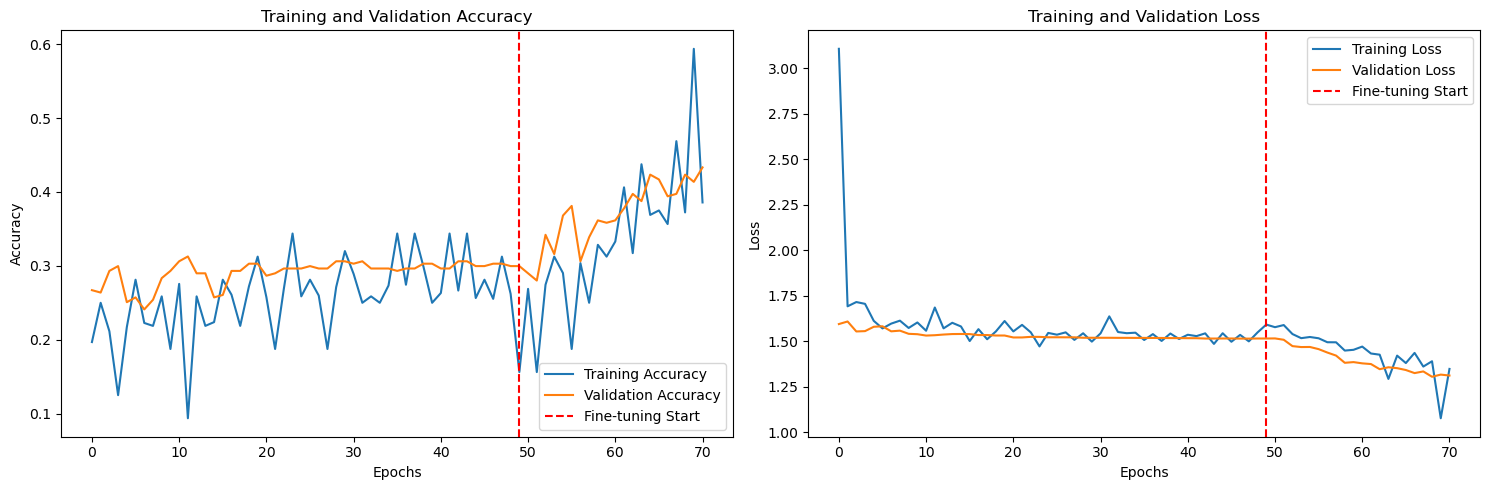

In [21]:
# Plot training history
def plot_training_history(history1, history2=None):
    """Plot training and validation accuracy and loss"""
    
    # Combine histories if fine-tuning was performed
    if history2 is not None:
        acc = history1.history['accuracy'] + history2.history['accuracy']
        val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
        loss = history1.history['loss'] + history2.history['loss']
        val_loss = history1.history['val_loss'] + history2.history['val_loss']
    else:
        acc = history1.history['accuracy']
        val_acc = history1.history['val_accuracy']
        loss = history1.history['loss']
        val_loss = history1.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    if history2 is not None:
        plt.axvline(x=len(history1.history['accuracy'])-1, color='r', linestyle='--', label='Fine-tuning Start')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    if history2 is not None:
        plt.axvline(x=len(history1.history['loss'])-1, color='r', linestyle='--', label='Fine-tuning Start')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history, history_fine)

Loading best model for evaluation...


10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.4960 - loss: 1.2808

Test Accuracy: 0.4430
Test Loss: 1.3167
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.40      0.06      0.11        62
       happy       0.53      0.62      0.57        61
     neutral       0.28      0.33      0.30        61
         sad       0.38      0.40      0.39        62
    surprise       0.56      0.80      0.66        61

    accuracy                           0.44       307
   macro avg       0.43      0.44      0.41       307
weighted avg       0.43      0.44      0.41       307



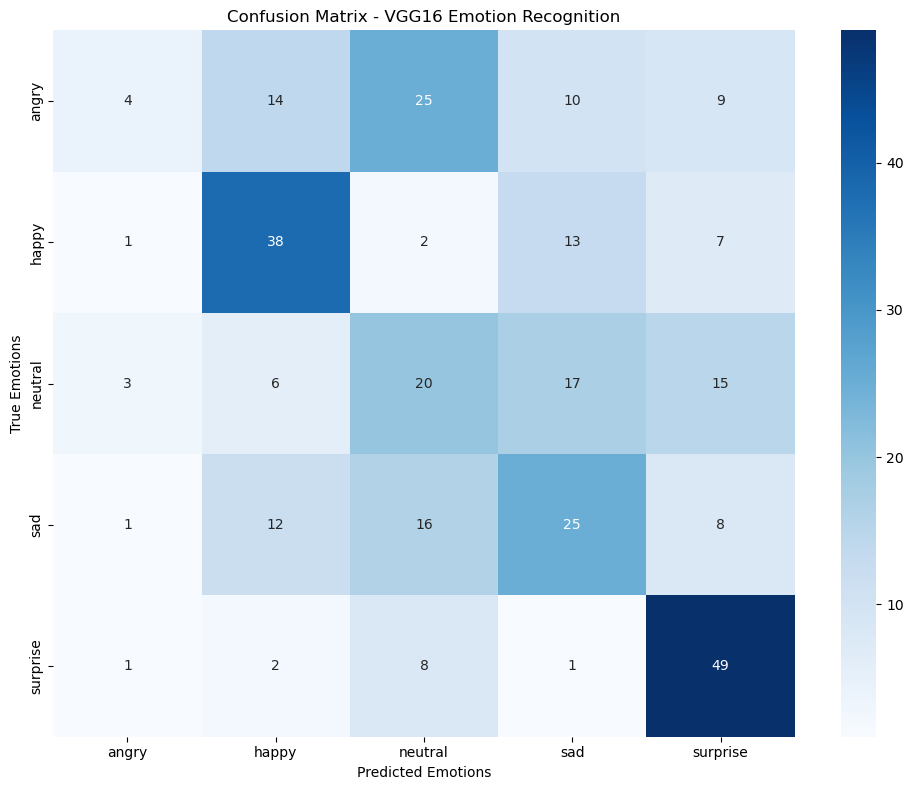

In [22]:
# Load the best model and evaluate on test set
print("Loading best model for evaluation...")

# Load the best saved model
best_model = tf.keras.models.load_model('best_vgg16_emotion_model.h5')

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions on test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=emotion_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.title('Confusion Matrix - VGG16 Emotion Recognition')
plt.xlabel('Predicted Emotions')
plt.ylabel('True Emotions')
plt.tight_layout()
plt.show()

In [23]:
# Save the final model
print("Saving final model...")
best_model.save('vgg16_final_emotion_model.h5')
print("Model saved as 'vgg16_final_emotion_model.h5'")

# Create inference function
def predict_emotion(image_path, model, emotion_classes, target_size=(224, 224)):
    """
    Predict emotion from an image
    
    Args:
        image_path: Path to the image file
        model: Trained model
        emotion_classes: List of emotion class names
        target_size: Target size for the image
    
    Returns:
        Predicted emotion and confidence scores
    """
    try:
        # Load and preprocess image
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class]
        
        # Get all class probabilities
        class_probabilities = {emotion_classes[i]: predictions[0][i] for i in range(len(emotion_classes))}
        
        return emotion_classes[predicted_class], confidence, class_probabilities
    
    except Exception as e:
        print(f"Error predicting emotion: {e}")
        return None, None, None

# Function to predict emotion from video frame
def predict_emotion_from_video(video_path, model, emotion_classes, target_size=(224, 224)):
    """
    Predict emotions from video frames
    """
    frames = extract_frames_from_video(video_path, target_size, max_frames=5)
    
    if not frames:
        print("No frames extracted from video")
        return None
    
    predictions = []
    for frame in frames:
        frame_expanded = np.expand_dims(frame, axis=0)
        pred = model.predict(frame_expanded, verbose=0)
        predicted_class = np.argmax(pred[0])
        confidence = pred[0][predicted_class]
        predictions.append((emotion_classes[predicted_class], confidence))
    
    # Get most common prediction
    emotion_counts = {}
    for emotion, conf in predictions:
        if emotion in emotion_counts:
            emotion_counts[emotion] += conf
        else:
            emotion_counts[emotion] = conf
    
    dominant_emotion = max(emotion_counts, key=emotion_counts.get)
    avg_confidence = emotion_counts[dominant_emotion] / len([p for p in predictions if p[0] == dominant_emotion])
    
    return dominant_emotion, avg_confidence, predictions

print("Inference functions created successfully!")
print("\nTraining completed! You can now use the model for emotion recognition.")

Saving final model...
Model saved as 'vgg16_final_emotion_model.h5'
Inference functions created successfully!

Training completed! You can now use the model for emotion recognition.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Predicted Emotion: happy
Confidence: 0.3349

All class probabilities:
angry: 0.2395
happy: 0.3349
neutral: 0.1734
sad: 0.2336
surprise: 0.0186


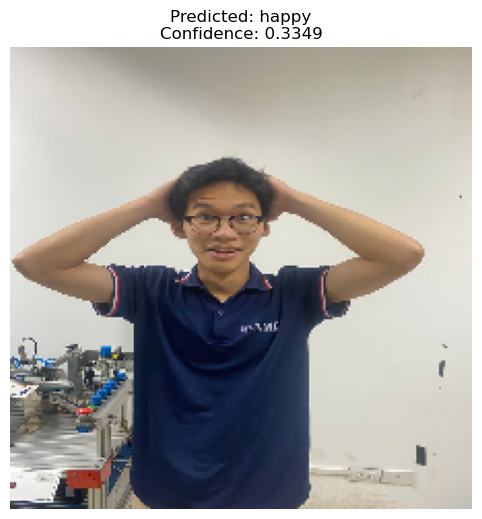

In [29]:
# Test the model on a specific image
sample_image_url = "C:\\Users\\DELL\\Downloads\\z6710436795790_d4c5bc4c51bf0aa0ab3764e4e6737f76.jpg"

# Use the predict_emotion function to test the image
predicted_emotion, confidence, class_probabilities = predict_emotion(
    sample_image_url, 
    best_model, 
    emotion_classes
)

if predicted_emotion:
    print(f"Predicted Emotion: {predicted_emotion}")
    print(f"Confidence: {confidence:.4f}")
    print("\nAll class probabilities:")
    for emotion, prob in class_probabilities.items():
        print(f"{emotion}: {prob:.4f}")
    
    # Display the image with prediction
    plt.figure(figsize=(8, 6))
    img_display = load_img(sample_image_url, target_size=(224, 224))
    plt.imshow(img_display)
    plt.title(f'Predicted: {predicted_emotion}\nConfidence: {confidence:.4f}')
    plt.axis('off')
    plt.show()
else:
    print("Error: Could not process the image")

## Summary

This notebook successfully trains a VGG16 model for emotion recognition with the following features:

### Key Components:
1. **Data Sources**: Combines local video data and FER2013 dataset from Kaggle
2. **Model Architecture**: VGG16 with custom classification layers
3. **Emotions Detected**: 5 classes - Angry, Happy, Sad, Neutral, Surprise
4. **Training Strategy**: Transfer learning with fine-tuning

### Required Packages:
Before running this notebook, install the required packages:

```bash
pip install tensorflow opencv-python matplotlib seaborn scikit-learn kagglehub pandas numpy
```

### Outputs:
- **Model Files**: 
  - `best_vgg16_emotion_model.h5` (best model during training)
  - `vgg16_final_emotion_model.h5` (final trained model)
- **Performance Metrics**: Classification report and confusion matrix
- **Inference Functions**: Ready-to-use functions for image and video emotion prediction

### Usage:
After training, you can use the trained model for real-time emotion recognition from images or video frames using the provided inference functions.